In [ ]:
# default_exp g_utils

In [ ]:
#hide_input
from pivotpy.g_utils import nav_links 
nav_links(4)

<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>
> [&nbsp;`▶` Index&nbsp;](https://massgh.github.io/pivotpy/)  
> [&nbsp;`▶` XmlElementTree&nbsp;](https://massgh.github.io/pivotpy/XmlElementTree)  
> [&nbsp;`▶` StaticPlots&nbsp;](https://massgh.github.io/pivotpy/StaticPlots)  
> [&nbsp;`▶` InteractivePlots&nbsp;](https://massgh.github.io/pivotpy/InteractivePlots)  
> [&nbsp;`▶` Utilities●&nbsp;](https://massgh.github.io/pivotpy/Utilities)  
> [&nbsp;`▶` StructureIO&nbsp;](https://massgh.github.io/pivotpy/StructureIO)  
> [&nbsp;`▶` Widgets&nbsp;](https://massgh.github.io/pivotpy/Widgets)  
> [&nbsp;`▶` MainAPI&nbsp;](https://massgh.github.io/pivotpy/MainAPI)  


# Utilities

> This includes generally useful functions, including running PowerShell commands from Python.

In [ ]:
#export 
import re
import os
import json
import glob
from collections import namedtuple
from subprocess import Popen, PIPE
from inspect import getcallargs as gcargs, signature
from io import StringIO
from itertools import islice # File generator for faster r
from contextlib import contextmanager

import numpy as np
import plotly.graph_objects as go
# Inside packages import to work both with package and jupyter notebook.
try:
    from pivotpy import vr_parser as vp
    from pivotpy import s_plots as sp
    from pivotpy import i_plots as ip
    from pivotpy import sio as sio
except:
    import pivotpy.vr_parser as vp
    import pivotpy.s_plots as sp
    import pivotpy.i_plots as ip
    import pivotpy.sio as sio

In [ ]:
#export
def get_file_size(path):
    """Return file size"""
    if os.path.isfile(path):
        size = os.stat(path).st_size
        for unit in ['Bytes','KB','MB','GB','TB']:
            if size < 1024.0:
                return "%3.2f %s" % (size,unit)
            size /= 1024.0
    else:
        return ''

@contextmanager
def set_dir(path):
    "work in some directory and come back"
    current = os.getcwd()
    try:
        os.chdir(path)
        yield
    finally:
        os.chdir(current)

In [ ]:
get_file_size('Utilities.ipynb')

'116.41 KB'

In [ ]:
#export
from scipy.interpolate import make_interp_spline, BSpline
def interpolate_data(x,y,n=10,k=3):
    """
    - Returns interpolated xnew,ynew. If two points are same, it will add 0.1*min(dx>0) to compensate it.
    - **Parameters**
        - x: 1D array of size p,
        - y: ndarray of size p*q*r,....
        - n: Number of points to add between two given points.
        - k: Polynomial order to interpolate.

    - Only axis 0 will be interpolated. If you want general interploation, use `from scipy.interpolate import make_interp_spline, BSpline`

    - **General Usage**: K(p),E(p,q) input from bandstructure.
        - `Knew,Enew= interpolate_data(K,E,n=10,k=3)`. cubic interploation
    """
    #Add very small values at simliar points to make interpolation work.
    ind=[i for i in range(0,len(x)) if x[i-1]==x[i]] #Duplicate indices
    xa=np.unique(x)
    dx=0.1*np.min(xa[1:]-xa[:-1])
    if(ind):
        for pt in ind:
            x[pt:]=x[pt:]-x[pt]+x[pt-1]+dx
    # Now Apply interpolation
    xnew=[np.linspace(x[i],x[i+1],n) for i in range(len(x)-1)]
    xnew=np.reshape(xnew,(-1))
    spl = make_interp_spline(x, y, k=k) #BSpline object
    ynew = spl(xnew)
    return xnew,ynew

In [ ]:
#export
def ps2py(ps_command='Get-ChildItem', exec_type='-Command', path_to_ps='powershell.exe'):
    """
    - Captures powershell output in python.
    - **Parameters**
        - ps_command: enclose ps_command in ' ' or " ".
        - exec_type : type of execution, default '-Command', could be '-File'.
        - path_to_ps: path to powerhell.exe if not added to PATH variables.
    """
    try: # Works on Linux and Windows if PS version > 5.
        cmd = ['pwsh', '-ExecutionPolicy', 'Bypass', exec_type, ps_command]
        proc = Popen(cmd, stdout=PIPE, stderr=PIPE)
    except FileNotFoundError:
        try: # Works only on Windows.
            cmd = ['powershell', '-ExecutionPolicy', 'Bypass', exec_type, ps_command]
            proc = Popen(cmd, stdout=PIPE, stderr=PIPE)
        except FileNotFoundError:
            # Works in case nothing above works and you know where is executable.
            cmd = [path_to_ps, '-ExecutionPolicy', 'Bypass', exec_type, ps_command]
            proc = Popen(cmd, stdout=PIPE, stderr=PIPE)

    out=[]; #save to out.
    while True:
        line = proc.stdout.readline()
        if line!=b'':
            line=line.strip()
            u_line=line.decode("utf-8")
            out.append(u_line)
        else:
            break
    out=[item for item in out if item!=''] #filter out empty lines
    return out

In [ ]:
#export
def ps2std(ps_command='Get-ChildItem', exec_type='-Command', path_to_ps='powershell.exe'):
    """
    - Prints powershell output in python std.
    - **Parameters**
        - ps_command: enclose ps_command in ' ' or " ".
        - exec_type: type of execution, default '-Command', could be '-File'.
        - path_to_ps: path to powerhell.exe if not added to PATH variables.
    """
    out = ps2py(path_to_ps=path_to_ps,exec_type=exec_type,ps_command=ps_command)
    for item in out:
        print(item)
    return None

- `ps2std` only outputs returns of powershell to python std.
- `ps2py`'s return could be manipulated in python.

In [ ]:
ps2std(ps_command='(Get-Process)[0..4]')

NPM(K)    PM(M)      WS(M)     CPU(s)      Id  SI Pr
oc
es
sN
am
e
------    -----      -----     ------      --  -- --
5     1.32       5.30       0.00    7052   0 A…
18     7.22      16.21       0.00    5104   0 A…
25    25.50      45.09       9.36   14344   1 A…
8     1.88       7.75       0.02   20412   1 A…
8     1.63       7.05       0.00   26512   0 A…


In [ ]:
pp=ps2py(ps_command='(Get-Process)[0..4]')
pp

['NPM(K)    PM(M)      WS(M)     CPU(s)      Id  SI Pr',
 'oc',
 'es',
 'sN',
 'am',
 'e',
 '------    -----      -----     ------      --  -- --',
 '5     1.32       5.30       0.00    7052   0 A…',
 '18     7.22      16.21       0.00    5104   0 A…',
 '25    25.50      45.09       9.36   14344   1 A…',
 '8     1.88       7.75       0.02   20412   1 A…',
 '8     1.63       7.05       0.00   26512   0 A…']

In [ ]:
#export
def get_child_items(path = os.getcwd(),depth=None,recursive=True,include=None,exclude=None,filesOnly=False,dirsOnly= False):
    """
    - Returns selected directories/files recursively from a parent directory.
    - **Parameters**
        - path    : path to a parent directory, default is `"."`
        - depth   : int, subdirectories depth to get recursively, default is None to list all down.
        - recursive : If False, only list current directory items, if True,list all items recursively down the file system.
        - include: Default is None and includes everything. String of patterns separated by | to keep, could be a regular expression.
        - exclude: Default is None and removes nothing. String of patterns separated by | to drop,could be a regular expression.
        - filesOnly : Boolean, if True, returns only files.
        - dirsOnly  : Boolean, if True, returns only directories.
    - **Returns**
        - GLOB : Tuple (children,parent), children is list of selected directories/files and parent is given path. Access by index of by `get_child_items().{children,path}`.
    """
    path = os.path.abspath(path) # important
    pattern = path + '**/**' # Default pattern
    if depth != None and type(depth) == int:
        pattern = path + '/'.join(['*' for i in range(depth+1)])
        if glob.glob(pattern) == []: #If given depth is more, fall back.
            pattern = path + '**/**' # Fallback to default pattern if more depth to cover all.
    glob_files = glob.iglob(pattern, recursive=recursive)
    if dirsOnly == True:
        glob_files = filter(lambda f: os.path.isdir(f),glob_files)
    if filesOnly == True:
        glob_files = filter(lambda f: os.path.isfile(f),glob_files)
    list_dirs=[]
    for g_f in glob_files:
        list_dirs.append(os.path.relpath(g_f,path))
    # Include check
    if include:
        list_dirs = [l for l in list_dirs if re.search(include,l)]
    # Exclude check
    if exclude:
        list_dirs = [l for l in list_dirs if not re.search(exclude,l)]
    # Keep only unique
    req_dirs = list(np.unique(list_dirs))
    out_files = namedtuple('GLOB',['children','parent'])
    return out_files(req_dirs,os.path.abspath(path))

In [ ]:
items = get_child_items(path="../",dirsOnly=True,include='Current',exclude='')
print(items.parent)
items.children

E:\Research


[]

In [ ]:
#export
def prevent_overwrite(path):
    """Prevents overwiting as file/directory by adding numbers in given file/directory path."""
    if os.path.exists(path):
        name, ext = os.path.splitext(path)
        # Check existing files
        i = 0
        _path = name + '-{}' + ext
        while os.path.isfile(_path.format(i)):
            i +=1
        out_path = _path.format(i)
        print(f"Found existing path: {path!r}\nConverting to: {out_path!r}")
        return out_path
    return path

In [ ]:
#export
class color:
     def bg(text,r,g,b):
          """Provide r,g,b component in range 0-255"""
          return f"\033[48;2;{r};{g};{b}m{text}\033[00m"
     def fg(text,r,g,b):
          """Provide r,g,b component in range 0-255"""
          return f"\033[38;2;{r};{g};{b}m{text}\033[00m"
     # Usual Colos
     r  = lambda text: f"\033[0;91m {text}\033[00m"
     rb = lambda text: f"\033[1;91m {text}\033[00m"
     g  = lambda text: f"\033[0;92m {text}\033[00m"
     gb = lambda text: f"\033[1;92m {text}\033[00m"
     b  = lambda text: f"\033[0;34m {text}\033[00m"
     bb = lambda text: f"\033[1;34m {text}\033[00m"
     y  = lambda text: f"\033[0;93m {text}\033[00m"
     yb = lambda text: f"\033[1;93m {text}\033[00m"
     m  = lambda text: f"\033[0;95m {text}\033[00m"
     mb = lambda text: f"\033[1;95m {text}\033[00m"
     c  = lambda text: f"\033[0;96m {text}\033[00m"
     cb = lambda text: f"\033[1;96m {text}\033[00m"

- `pivotpy.g_utils.color` contains following attributes:          
 color.r  --> red       
 color.rb --> red-bold            
 color.g  --> green           
 color.gb --> green-bold             
 color.b  --> blue            
 color.bb --> blue-bold          
 color.y  --> yellow           
 color.yb --> yellow-bold              
 color.m  --> magenta                
 color.mb --> magenta-bold                 
 color.c  --> cyan              
 color.cb --> cyan-bold    
- **Usage**: print(color.r('This is red'))           

In [ ]:
#export
class EncodeFromNumpy(json.JSONEncoder):
    """
    - Serializes python/Numpy objects via customizing json encoder.
    - **Usage**
        - `json.dumps(python_dict, cls=EncodeFromNumpy)` to get json string.
        - `json.dump(*args, cls=EncodeFromNumpy)` to create a file.json.
    """
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return {
                "_kind_": "ndarray",
                "_value_": obj.tolist()
            }
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj,range):
            value = list(obj)
            return {
                "_kind_" : "range",
                "_value_" : [value[0],value[-1]+1]
            }
        return super(EncodeFromNumpy, self).default(obj)



class DecodeToNumpy(json.JSONDecoder):
    """
    - Deserilizes JSON object to Python/Numpy's objects.
    - **Usage**
        - `json.loads(json_string,cls=DecodeToNumpy)` from string, use `json.load()` for file.
    """
    def __init__(self, *args, **kwargs):
        json.JSONDecoder.__init__(self, object_hook=self.object_hook, *args, **kwargs)

    def object_hook(self, obj):
        if '_kind_' not in obj:
            return obj
        kind = obj['_kind_']
        if kind == 'ndarray':
            return np.array(obj['_value_'])
        elif kind == 'range':
            value = obj['_value_']
            return range(value[0],value[-1])
        return obj

In [ ]:
import json
import pivotpy as pp
vr=pp.Vasprun(path = "E:/Research/graphene_example/ISPIN_2/bands/vasprun.xml" ,skipk=88,elim=[0,5]).data
print("ORIGINAL DATA : {}\n".format(vr.poscar.to_dict()))
s=json.dumps(vr.poscar.to_dict(), cls=EncodeFromNumpy)
print("JSON STRING : {}\n".format(s))
s2 = json.loads(s, cls=DecodeToNumpy)
print("RETRIEVED DATA : {}".format(s2))

ORIGINAL DATA : {'SYSTEM': 'C2', 'volume': 105.49324928, 'basis': array([[ 2.468031,  0.      ,  0.      ],
       [-1.234015,  2.137377,  0.      ],
       [ 0.      ,  0.      , 19.998293]]), 'rec_basis': array([[0.4051813 , 0.2339315 , 0.        ],
       [0.        , 0.46786318, 0.        ],
       [0.        , 0.        , 0.05000427]]), 'positions': array([[0.333333, 0.666667, 0.      ],
       [0.666667, 0.333333, 0.      ]]), 'labels': ['C 1', 'C 2'], 'unique': {'C': range(0, 2)}, 'text_plain': 'C2  # Created by Pivotpy\n  2.46803100000000    \n    1.0000000000000000    0.0000000000000000    0.0000000000000000\n   -0.4999997974093519    0.8660251836382931    0.0000000000000000\n    0.0000000000000000    0.0000000000000000    8.1029342824300024\n  C\n  2\nDirect\n   0.3333330000000000   0.6666670000000000   0.0000000000000000\n   0.6666670000000000   0.3333330000000000   0.0000000000000000'}

JSON STRING : {"SYSTEM": "C2", "volume": 105.49324928, "basis": {"_kind_": "ndarray", "_

In [ ]:
#export
def nav_links(current_index=0,
            doc_url = r"https://massgh.github.io/pivotpy/",
            items   = ["Index",
                       "XmlElementTree",
                       "StaticPlots",
                       "InteractivePlots",
                       "Utilities",
                       "StructureIO",
                       "Widgets",
                       "MainAPI"
                       ],
            horizontal = False,
            out_string = False):
    from IPython.display import Markdown
    links   = [doc_url+item if not 'Index' in item else doc_url for item in items]
    style = """<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>\n"""
    md_str = style
    for i,(link,item) in enumerate(zip(links,items)):
        if current_index == i: item = "{}●".format(item)
        if not horizontal:
            md_str += "> [&nbsp;`▶` {}&nbsp;]({})  \n".format(item,link)
        else:
            md_str += "> [&nbsp;`▶` {}&nbsp;]({})\n".format(item,link)
    if out_string:
        return md_str
    return Markdown(md_str)

In [ ]:
#export
def export_outcar(path=None):
    """
    - Read potential at ionic sites from OUTCAR.
    """
    if path is None:
        path = './OUTCAR'
    if not os.path.isfile(path):
        raise FileNotFoundError("{} does not exist!".format(path))
    # Raeding it
    with open(r'{}'.format(path),'r') as f:
        lines = f.readlines()
    # Processing
    for i,l in enumerate(lines):
        if 'NIONS' in l:
            N = int(l.split()[-1])
            nlines = np.ceil(N/5).astype(int)
        if 'electrostatic' in l:
            start_index = i+3
            stop_index = start_index+nlines
        if 'fractional' in l:
            first = i+1
        if 'vectors are now' in l:
            b_first = i+5
        if 'NION' in l:
            ion_line = l
        if 'NKPTS' in l:
            kpt_line =l

    NKPTS,NKDIMS,NBANDS = [int(v) for v in re.findall(r"\d+",kpt_line)]
    NEDOS,NIONS = [int(v) for v in re.findall(r"\d+",ion_line)]
    n_kbi = (NKPTS,NBANDS,NIONS)
    # Data manipulation
    # Potential
    data = lines[start_index:stop_index]
    initial = np.loadtxt(StringIO(''.join(data[:-1]))).reshape((-1))
    last = np.loadtxt(StringIO(data[-1]))
    pot_arr = np.hstack([initial,last]).reshape((-1,2))
    pot_arr[:,0] = pot_arr[:,0]-1 # Ion index fixing
    # Nearest neighbors
    pos = lines[first:first+N]
    pos_arr = np.loadtxt(StringIO('\n'.join(pos)))
    pos_arr[pos_arr>0.98] = pos_arr[pos_arr>0.98]-1 # Fixing outer layers
    # positions and potential
    pos_pot = np.hstack([pos_arr,pot_arr[:,1:]])
    basis = np.loadtxt(StringIO(''.join(lines[b_first:b_first+3])))
    final_dict = {'ion_pot':pot_arr,'positions':pos_arr,'site_pot':pos_pot,'basis':basis[:,:3],'rec_basis':basis[:,3:],'n_kbi':n_kbi}
    return vp.Dict2Data(final_dict)

In [ ]:
#export
def export_potential(locpot=None,e = True,m = False):
    """
    - Returns Data from LOCPOT and similar structure files like CHG. Loads only single set out of 2/4 magnetization data to avoid performance/memory cost while can load electrostatic and one set of magnetization together.
    - **Parameters**
        - locpot: path/to/LOCPOT or similar stuructured file like CHG. LOCPOT is auto picked in CWD.
        - e     : Electric potential/charge density. Default is True.
        - m     : Magnetization density m. Default is False. If True, picks `m` for spin polarized case, and `m_x` for non-colinear case. Additionally it can take 'x','y' and 'z' in case of non-colinear calculations.
    - **Exceptions**
        - Would raise index error if magnetization density set is not present in LOCPOT/CHG in case `m` is not False.
    """
    if locpot is None:
        if os.path.isfile('LOCPOT'):
            locpot = 'LOCPOT'
        else:
            raise FileNotFoundError('./LOCPOT not found.')
    else:
        if not os.path.isfile(locpot):
            raise FileNotFoundError("File {!r} does not exist!".format(locpot))
    if m not in [True,False,'x','y','z']:
        raise ValueError("m expects one of [True,False,'x','y','z'], got {}".format(e))
    # data fixing after reading islice from file.
    def fix_data(islice_gen,shape):
        new_gen = (float(l) for line in islice_gen for l in line.split())
        COUNT = np.prod(shape).astype(int)
        data = np.fromiter(new_gen,dtype=float,count=COUNT) # Count is must for performance
        # data written on LOCPOT is in shape of (NGz,NGy,NGx)
        N_reshape = [shape[2],shape[1],shape[0]]
        data = data.reshape(N_reshape).transpose([2,1,0])
        return data
    # Reading File
    with open(locpot,'r') as f:
        lines = []
        f.seek(0)
        for i in range(8):
            lines.append(f.readline())
        N = sum([int(v) for v in lines[6].split()])
        f.seek(0)
        poscar = []
        for i in range(N+8):
            poscar.append(f.readline())
        f.readline() # Empty one
        Nxyz = [int(v) for v in f.readline().split()] # Grid line read
        nlines = np.ceil(np.prod(Nxyz)/5).astype(int)
        #islice is faster generator for reading potential
        pot_dict = {}
        if e == True:
            pot_dict.update({'e':fix_data(islice(f, nlines),Nxyz)})
            ignore_set = 0 # Pointer already ahead.
        else:
            ignore_set = nlines # Needs to move pointer to magnetization
        #reading Magnetization if True
        ignore_n = np.ceil(N/5).astype(int)+1 #Some kind of useless data
        if m == True:
            print("m = True would pick m_x for non-colinear case, and m for ISPIN=2.\nUse m='x' for non-colinear or keep in mind that m will refer to m_x.")
            start = ignore_n+ignore_set
            pot_dict.update({'m': fix_data(islice(f, start,start+nlines),Nxyz)})
        elif m == 'x':
            start = ignore_n+ignore_set
            pot_dict.update({'m_x': fix_data(islice(f, start,start+nlines),Nxyz)})
        elif m == 'y':
            start = 2*ignore_n+nlines+ignore_set
            pot_dict.update({'m_y': fix_data(islice(f, start,start+nlines),Nxyz)})
        elif m == 'z':
            start = 3*ignore_n+2*nlines+ignore_set
            pot_dict.update({'m_z': fix_data(islice(f, start,start+nlines),Nxyz)})

    # Read Info
    basis = np.loadtxt(StringIO(''.join(poscar[2:5])))*float(poscar[1].strip())
    system = poscar[0].strip()
    ElemName = poscar[5].split()
    ElemIndex = [int(v) for v in poscar[6].split()]
    ElemIndex.insert(0,0)
    ElemIndex = list(np.cumsum(ElemIndex))
    positions = np.loadtxt(StringIO(''.join(poscar[8:N+9])))

    final_dict = dict(SYSTEM=system,ElemName=ElemName,ElemIndex=ElemIndex,basis=basis,positions=positions)
    final_dict = {**final_dict,**pot_dict}
    return vp.Dict2Data(final_dict)

In [ ]:
#export
def transform_color(arr,s=1,c=1,b=0,mixing_matrix=None):
    """
    - Color transformation such as brightness, contrast, saturation and mixing of an input color array. `c = -1` would invert color,keeping everything else same.
    - **Parameters**
        - arr: input array, a single RGB/RGBA color or an array with inner most dimension equal to 3 or 4. e.g. [[[0,1,0,1],[0,0,1,1]]].
        - c  : contrast, default is 1. Can be a float in [-1,1].
        - s  : saturation, default is 1. Can be a float in [-1,1]. If s = 0, you get a gray scale image.
        - b  : brightness, default is 0. Can be a float in [-1,1] or list of three brightnesses for RGB components.
        - mixing_matrix: A 3x3 matrix to mix RGB values, such as `pp.color_matrix`.

    [Recoloring](https://docs.microsoft.com/en-us/windows/win32/gdiplus/-gdiplus-recoloring-use?redirectedfrom=MSDN)
    [Rainmeter](https://docs.rainmeter.net/tips/colormatrix-guide/)
    """
    arr = np.array(arr) # Must
    t = (1-c)/2 # For fixing gray scale when contrast is 0.
    whiteness = np.array(b)+t # need to clip to 1 and 0 after adding to color.
    sr = (1-s)*0.2125 #red saturation from red luminosity
    sg = (1-s)*0.7154 #green saturation from green luminosity
    sb = (1-s)*0.0721 #blue saturation from blue luminosity
    # trans_matrix is multiplied from left, or multiply its transpose from right.
    # trans_matrix*color is not normalized but value --> value - int(value) to keep in [0,1].
    trans_matrix = np.array([
        [c*(sr+s), c*sg,      c*sb],
        [c*sr,   c*(sg+s),    c*sb],
        [c*sr,     c*sg,  c*(sb+s)]])
    if np.ndim(arr) == 1:
        new_color = np.dot(trans_matrix,arr)
    else:
        new_color = np.dot(arr[...,:3],trans_matrix.T)
    if mixing_matrix is not None and np.size(mixing_matrix)==9:
        new_color = np.dot(new_color,np.transpose(mixing_matrix))
    new_color[new_color > 1] = new_color[new_color > 1] - new_color[new_color > 1].astype(int)
    new_color = np.clip(new_color + whiteness,a_max=1,a_min=0)
    if np.shape(arr)[-1]==4:
        axis = len(np.shape(arr))-1 #Add back Alpha value if present
        new_color = np.concatenate([new_color,arr[...,3:]],axis=axis)
    return new_color

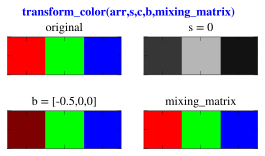

In [ ]:
import matplotlib.pyplot as plt,pivotpy as pp 
axs = pp.get_axes(nrows=2,ncols=2,figsize=(4.5,2.5))
carr = [[[1,0,0,1],[0,1,0,1],[0,0,1,1]]]
axs[0,0].imshow(transform_color(arr=carr))
axs[0,1].imshow(transform_color(s=0,arr=carr))
axs[1,0].imshow(transform_color(b=[-0.5,0,0],arr=carr))
axs[1,1].imshow(transform_color(arr=carr,mixing_matrix=pp.color_matrix[:,:3]))
for ax,txt in zip(axs.ravel(),['original','s = 0','b = [-0.5,0,0]','mixing_matrix']):
    ax.set_title(txt)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
_ = plt.gcf().suptitle('transform_color(arr,s,c,b,mixing_matrix)',color='b',fontweight='bold')

In [ ]:
#hide_input
nav_links(4)

<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>
> [&nbsp;`▶` Index&nbsp;](https://massgh.github.io/pivotpy/)  
> [&nbsp;`▶` XmlElementTree&nbsp;](https://massgh.github.io/pivotpy/XmlElementTree)  
> [&nbsp;`▶` StaticPlots&nbsp;](https://massgh.github.io/pivotpy/StaticPlots)  
> [&nbsp;`▶` InteractivePlots&nbsp;](https://massgh.github.io/pivotpy/InteractivePlots)  
> [&nbsp;`▶` Utilities●&nbsp;](https://massgh.github.io/pivotpy/Utilities)  
> [&nbsp;`▶` StructureIO&nbsp;](https://massgh.github.io/pivotpy/StructureIO)  
> [&nbsp;`▶` Widgets&nbsp;](https://massgh.github.io/pivotpy/Widgets)  
> [&nbsp;`▶` MainAPI&nbsp;](https://massgh.github.io/pivotpy/MainAPI)  
